# Setup

In [1]:
#get gpu info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jun  5 04:41:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#mount with google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#install transformers
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 8.8 MB/s 
     |████████████████████████████████| 596 kB 57.7 MB/s 
     |████████████████████████████████| 6.6 MB 45.3 MB/s 
     |████████████████████████████████| 86 kB 6.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
#import libraries
from google.colab import files
import io
import requests
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (11, 8) #default plot size
import seaborn as sns
from transformers import RobertaTokenizer
from transformers import TFAutoModel
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

#set common seed
seed_value=66
import os 
os.environ['PYTHONHASHSEED']=str(seed_value)
import random 
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [5]:
#upload train file
uploaded = files.upload()

Saving train_set.csv to train_set.csv


In [6]:
data = io.BytesIO(uploaded['train_set.csv'])

In [7]:
df_train = pd.read_csv(data)

In [8]:
#upload validation file
uploaded = files.upload()

Saving validation_set.csv to validation_set.csv


In [9]:
data = io.BytesIO(uploaded['validation_set.csv'])
df_val = pd.read_csv(data)

In [10]:
#upload test file
uploaded = files.upload()

Saving test_set.csv to test_set.csv


In [11]:
data = io.BytesIO(uploaded['test_set.csv'])
df_test = pd.read_csv(data)

In [12]:
#combinnig 3 df into 1
df_combined = pd.concat([df_train, df_val, df_test])

In [13]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 997 entries, 0 to 224
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 997 non-null    int64  
 1   person_name        997 non-null    object 
 2   nine_box_category  997 non-null    object 
 3   feedback           997 non-null    object 
 4   adjusted           772 non-null    object 
 5   reviewed           997 non-null    bool   
 6   label              997 non-null    int64  
 7   feedback_len       772 non-null    float64
 8   num_of_sent        772 non-null    float64
 9   performance_class  997 non-null    int64  
 10  potential_class    997 non-null    int64  
 11  feedback_clean     997 non-null    object 
 12  data_type          772 non-null    object 
 13  updated            225 non-null    object 
dtypes: bool(1), float64(2), int64(4), object(7)
memory usage: 110.0+ KB


In [14]:
#keep only required columns
df = df_combined.loc[:,['id','feedback','performance_class','potential_class']]

In [15]:
df.describe()

,id,performance_class,potential_class
count,997.000000,997.000000,997.000000
mean,6454.894684,1.019057,0.933801
std,7992.386895,0.811958,0.802626
min,1.000000,0.000000,0.000000
25%,293.000000,0.000000,0.000000
50%,606.000000,1.000000,1.000000
75%,10183.000000,2.000000,2.000000
max,20233.000000,2.000000,2.000000


In [16]:
df.isnull().sum()

id                   0
feedback             0
performance_class    0
potential_class      0
dtype: int64

In [17]:
#function to categorize & label each sample
def pre_label(df):
  df['total_score'] = df['performance_class'] + df['potential_class']
  
  #categorize total score into 5 categories: observe/exit = 0 |observe = 1| develop = 2 | develop/stretch=3 | stretch=4
  df['label'] = 2 #develop
  df.loc[df['total_score'] == 0, 'label'] = 0 #observe/exit
  df.loc[df['total_score'] == 4, 'label'] = 4 #stretch
  df.loc[df['total_score'] == 3, 'label'] = 3 #develop/stretch
  df.loc[df['total_score'] == 1, 'label'] = 1 #observe
  return df

In [18]:
#label sentiment sample
pre_label(df)

,id,feedback,performance_class,potential_class,total_score,label
0,1,John has not progressed in his position. He is...,0,0,0,0
1,10045,Douglas Henry has been having trouble in all a...,0,0,0,0
2,10044,Douglas has a lot to work on and areas to grow...,0,0,0,0
3,10005,"Freddie is a nice guy, but his performance and...",0,0,0,0
4,10004,Freddie has been quite disappointing this quar...,0,0,0,0
...,...,...,...,...,...,...
220,20124,Aydin Pitts has been a hugely beneficial part ...,2,2,4,4
221,20125,Aydin Pitts is as good as it gets. No flaw in ...,2,2,4,4
222,20154,Rachel Harper is a true virtuoso when it comes...,2,2,4,4
223,20083,Aubri is a rising example! Shes works until sh...,2,2,4,4


In [19]:
df['label'].value_counts()

2    297
1    229
3    204
0    139
4    128
Name: label, dtype: int64

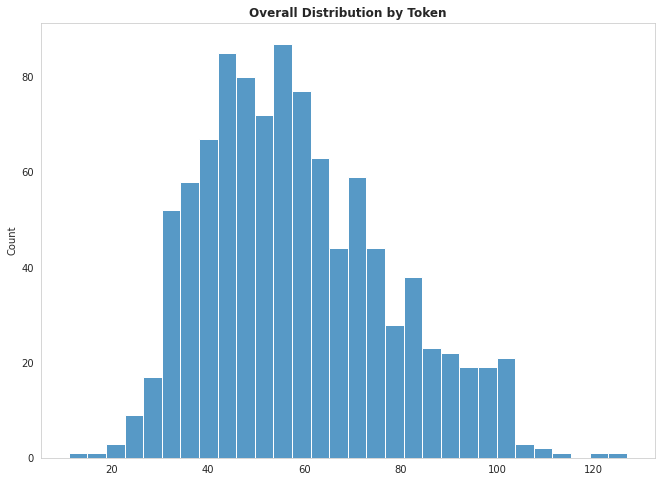

In [20]:
#check token size
sns.set_style("whitegrid", {'axes.grid' : False})
seq_len = [len(i.split()) for i in df['feedback']]

chart = sns.histplot(pd.Series(seq_len), bins = 30)
chart.set_title('Overall Distribution by Token',fontweight='bold',size='large');

In [21]:
#set length 
seq_len = 256
num_samples = len(df)
num_samples, seq_len

(997, 256)

# Preprocessing

In [23]:
#load tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

#tokenize with return tensor as numpy
tokens = tokenizer(df['feedback'].tolist(), max_length=seq_len, truncation=True,
                   padding='max_length', add_special_tokens=True,
                   return_tensors='np')

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [24]:
tokens.keys()

dict_keys(['input_ids', 'attention_mask'])

In [25]:
tokens['input_ids'][:10]

array([[    0, 10567,    34, ...,     1,     1,     1],
       [    0, 39756, 39473, ...,     1,     1,     1],
       [    0, 39756, 39473, ...,     1,     1,     1],
       ...,
       [    0, 10980,     4, ...,     1,     1,     1],
       [    0, 19842,   523, ...,     1,     1,     1],
       [    0,   894,    34, ...,     1,     1,     1]])

In [26]:
Xids = tokens['input_ids']

In [27]:
tokens['attention_mask'][:10]

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [28]:
Xmasks = tokens['attention_mask']

In [29]:
#create array to contain value from label column
arr = df['label'].values

In [30]:
#create zero array
labels = np.zeros((num_samples, arr.max()+1))
labels.shape

(997, 5)

In [31]:
#one-hot encoding for sentiment labels
labels[np.arange(num_samples), arr] = 1

labels

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [32]:
#create TF dataset object
tf.random.set_seed(66)
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmasks, labels))

#check first item
dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.int64, name=None), TensorSpec(shape=(256,), dtype=tf.int64, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [33]:
#function to convert 3-item tuple into 2-item tuple (input_item_dict, output_label) to feed to the model 
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

dataset = dataset.map(map_func)

dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.int64, name=None)}, TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [34]:
#data batching with shuffle
batch_size = 8

dataset = dataset.shuffle(num_samples, seed=66).batch(batch_size, drop_remainder=True)

dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(8, 256), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(8, 256), dtype=tf.int64, name=None)}, TensorSpec(shape=(8, 5), dtype=tf.float64, name=None))>

In [35]:
train_ds = dataset.take(82) #656 samples/8 per batch = 82 
val_ds = dataset.skip(82).take(15) #120 samples/8 per batch = 15
test_ds = dataset.skip(82).skip(15) #remaining samples
del dataset

In [36]:
#save tf dataset
tf.data.experimental.save(train_ds, 'train')
tf.data.experimental.save(val_ds, 'val')
tf.data.experimental.save(test_ds, 'test')

In [37]:
#check element specs
train_ds.element_spec
val_ds.element_spec
test_ds.element_spec

({'attention_mask': TensorSpec(shape=(8, 256), dtype=tf.int64, name=None),
  'input_ids': TensorSpec(shape=(8, 256), dtype=tf.int64, name=None)},
 TensorSpec(shape=(8, 5), dtype=tf.float64, name=None))

# Model Creation & Training

In [38]:
#initialize model
roberta = TFAutoModel.from_pretrained('roberta-base')

#view the model summary
roberta.summary()

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "tf_roberta_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124645632 
 )                                                               
                                                                 
Total params: 124,645,632
Trainable params: 124,645,632
Non-trainable params: 0
_________________________________________________________________


In [39]:
#stacking model layers; using functional approach for more flexibility
# two input layers
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

# transformer
embeddings = roberta.roberta(input_ids, attention_mask=mask)[1] 

# hidden layers
x = tf.keras.layers.Dense(128, activation='relu')(embeddings)
x = tf.keras.layers.Dropout(0.2, seed=seed_value)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2, seed=seed_value)(x)

# output layer
y = tf.keras.layers.Dense(5, activation='softmax')(x)

In [40]:
# initialize model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# print out model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 roberta (TFRobertaMainLayer)   TFBaseModelOutputWi  124645632   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

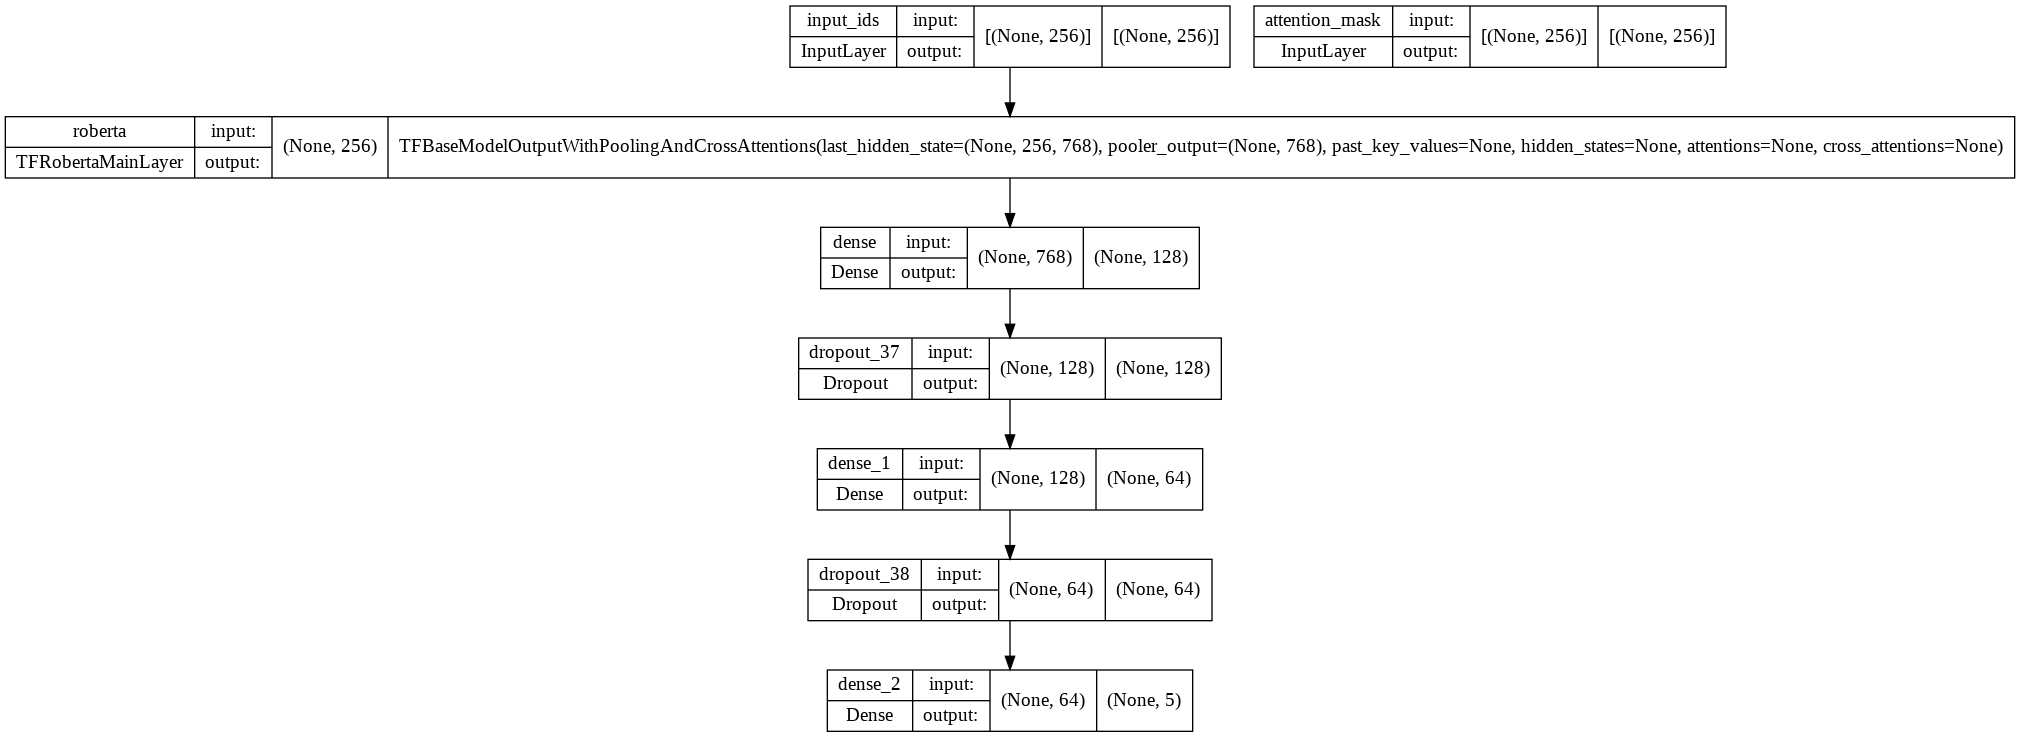

In [41]:
#plot the model
tf.keras.utils.plot_model(model, show_shapes=True)

In [42]:
#set optimizer, loss, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')
recall = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()

model.compile(optimizer=optimizer, loss=loss, metrics=[acc, recall, precision])

In [43]:
element_spec = ({'input_ids': tf.TensorSpec(shape=(8, 256), dtype=tf.int64, name=None),
  'attention_mask': tf.TensorSpec(shape=(8, 256), dtype=tf.int64, name=None)},
 tf.TensorSpec(shape=(8, 5), dtype=tf.float64, name=None))

# load the training and validation sets
train_ds = tf.data.experimental.load('train', element_spec=element_spec)
val_ds = tf.data.experimental.load('val', element_spec=element_spec)

# view the input format
train_ds.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(8, 256), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(8, 256), dtype=tf.int64, name=None)}, TensorSpec(shape=(8, 5), dtype=tf.float64, name=None))>

In [44]:
#set early stopping; model should stop trainng when val_loss does not decrease after 3 epochs
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)

In [45]:
#fit the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs= 30,
    callbacks = [earlystop_callback]
)

Epoch 1/30
82/82 [==============================] - 40s 330ms/step - loss: 1.6071 - accuracy: 0.2622 - recall: 0.0015 - precision: 1.0000 - val_loss: 1.5662 - val_accuracy: 0.2833 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/30
82/82 [==============================] - 24s 295ms/step - loss: 1.4790 - accuracy: 0.3247 - recall: 0.0274 - precision: 0.6667 - val_loss: 1.2150 - val_accuracy: 0.4417 - val_recall: 0.0917 - val_precision: 0.6111
Epoch 3/30
82/82 [==============================] - 24s 294ms/step - loss: 1.1311 - accuracy: 0.4817 - recall: 0.2744 - precision: 0.6338 - val_loss: 0.8296 - val_accuracy: 0.6833 - val_recall: 0.5000 - val_precision: 0.7059
Epoch 4/30
82/82 [==============================] - 24s 294ms/step - loss: 0.8199 - accuracy: 0.6753 - recall: 0.5046 - precision: 0.7438 - val_loss: 0.6556 - val_accuracy: 0.7083 - val_recall: 0.6250 - val_precision: 0.7426
Epoch 5/30
82/82 [==============================] - 24s 294ms/step - loss: 0.7018 - accuracy

In [46]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'recall', 'precision', 'val_loss', 'val_accuracy', 'val_recall', 'val_precision'])


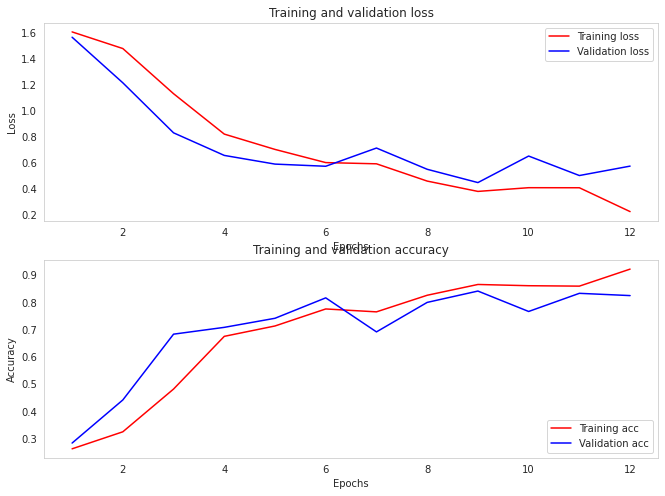

In [47]:
#plot training loss & accuracy rate
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(11, 8))
fig.tight_layout()

#training loss plot
plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#training accuracy
plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [48]:
model.save('saved_model/sentiment_model_roberta.h5') 

In [49]:
model.save('saved_model/sentiment_model_roberta')

INFO:tensorflow:Assets written to: saved_model/sentiment_model_roberta/assets


INFO:tensorflow:Assets written to: saved_model/sentiment_model_roberta/assets


# Prediction

In [50]:
test_ds = tf.data.experimental.load('test', element_spec=test_ds.element_spec)

In [51]:
#get valuation scores
val_results = model.evaluate(val_ds)
print(val_results)

15/15 [==============================] - 1s 92ms/step - loss: 0.4464 - accuracy: 0.8417 - recall: 0.8417 - precision: 0.8487
[0.4463546574115753, 0.8416666388511658, 0.8416666388511658, 0.848739504814148]


In [52]:
#get test score
test_results = model.evaluate(test_ds)
print(test_results)

27/27 [==============================] - 2s 91ms/step - loss: 0.4425 - accuracy: 0.8519 - recall: 0.8472 - precision: 0.8512
[0.4424508512020111, 0.8518518805503845, 0.8472222089767456, 0.8511627912521362]


In [53]:
#predict test set
y_pred = tf.nn.softmax(model.predict(test_ds))

In [54]:
y_pred

<tf.Tensor: shape=(216, 5), dtype=float32, numpy=
array([[0.40339023, 0.1492311 , 0.14902623, 0.14909324, 0.1492592 ],
       [0.40316758, 0.149279  , 0.14905249, 0.14913136, 0.14936958],
       [0.1497465 , 0.14973785, 0.1496936 , 0.15091583, 0.39990622],
       ...,
       [0.14990917, 0.4002122 , 0.15017903, 0.14995913, 0.14974041],
       [0.15171736, 0.15235704, 0.38311064, 0.1604146 , 0.15240037],
       [0.159009  , 0.15901601, 0.21180429, 0.30929068, 0.16087997]],
      dtype=float32)>

In [55]:
#convert probability to closet label
y_pred_argmax = tf.math.argmax(y_pred, axis=1)

In [56]:
y_pred_argmax

<tf.Tensor: shape=(216,), dtype=int64, numpy=
array([0, 0, 4, 2, 1, 1, 0, 2, 2, 2, 0, 4, 2, 2, 3, 2, 2, 4, 4, 3, 0, 3,
       2, 0, 3, 3, 4, 4, 2, 4, 3, 2, 1, 1, 1, 1, 3, 1, 2, 1, 4, 4, 3, 2,
       0, 2, 1, 1, 2, 3, 3, 4, 1, 3, 3, 1, 4, 2, 4, 4, 2, 1, 2, 2, 1, 3,
       0, 2, 1, 1, 1, 4, 1, 0, 2, 4, 1, 0, 0, 0, 3, 2, 0, 1, 2, 2, 2, 2,
       2, 2, 1, 3, 2, 2, 2, 4, 2, 1, 0, 3, 1, 2, 3, 2, 4, 0, 3, 0, 3, 2,
       2, 3, 4, 3, 1, 0, 1, 2, 2, 2, 2, 2, 1, 4, 0, 1, 0, 4, 4, 4, 2, 3,
       1, 2, 2, 0, 0, 4, 2, 2, 2, 0, 2, 1, 0, 2, 1, 0, 0, 3, 2, 2, 4, 2,
       4, 1, 1, 2, 4, 0, 3, 1, 0, 4, 0, 1, 3, 2, 4, 1, 0, 1, 0, 0, 1, 1,
       3, 3, 2, 1, 1, 1, 1, 3, 2, 3, 0, 2, 1, 3, 1, 3, 2, 2, 0, 1, 3, 3,
       3, 1, 4, 4, 2, 3, 3, 4, 4, 1, 1, 1, 2, 4, 2, 1, 2, 3])>

In [57]:
#convert y_true to label for comparison
y_true = tf.Variable([], dtype=tf.int64)

for features, label in test_ds.take(-1):
    print(label)
    y_true = tf.concat([y_true, np.argmax(label, axis=1)], 0)

tf.Tensor(
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]], shape=(8, 5), dtype=float64)
tf.Tensor(
[[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]], shape=(8, 5), dtype=float64)
tf.Tensor(
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]], shape=(8, 5), dtype=float64)
tf.Tensor(
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]], shape=(8, 5), dtype=float64)
tf.Tensor(
[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]], shape=(8, 5), dtype=float64)
tf.Tensor(
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 

In [58]:
y_true

<tf.Tensor: shape=(216,), dtype=int64, numpy=
array([0, 0, 4, 2, 1, 1, 0, 3, 1, 2, 0, 4, 3, 2, 3, 1, 2, 4, 4, 2, 0, 3,
       2, 1, 3, 3, 4, 3, 2, 4, 3, 2, 1, 1, 1, 1, 3, 1, 2, 1, 4, 4, 3, 2,
       0, 2, 1, 1, 3, 3, 3, 4, 1, 3, 4, 1, 4, 2, 3, 4, 2, 1, 2, 2, 1, 3,
       1, 2, 1, 1, 1, 4, 1, 0, 2, 4, 1, 0, 0, 0, 3, 2, 0, 1, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 1, 2, 3, 2, 1, 0, 3, 1, 2, 3, 1, 3, 0, 2, 0, 3, 2,
       2, 3, 4, 3, 1, 0, 1, 1, 2, 2, 2, 3, 1, 3, 0, 1, 0, 4, 4, 4, 2, 2,
       1, 2, 2, 0, 1, 4, 2, 2, 2, 0, 2, 1, 0, 2, 1, 0, 0, 3, 2, 2, 4, 2,
       4, 1, 1, 2, 4, 0, 2, 1, 0, 4, 0, 1, 3, 2, 4, 1, 0, 1, 0, 0, 1, 2,
       3, 3, 2, 1, 1, 1, 1, 3, 3, 3, 0, 2, 1, 2, 1, 3, 2, 2, 0, 1, 3, 3,
       2, 2, 4, 4, 3, 4, 3, 3, 4, 1, 1, 1, 2, 2, 2, 1, 2, 3])>

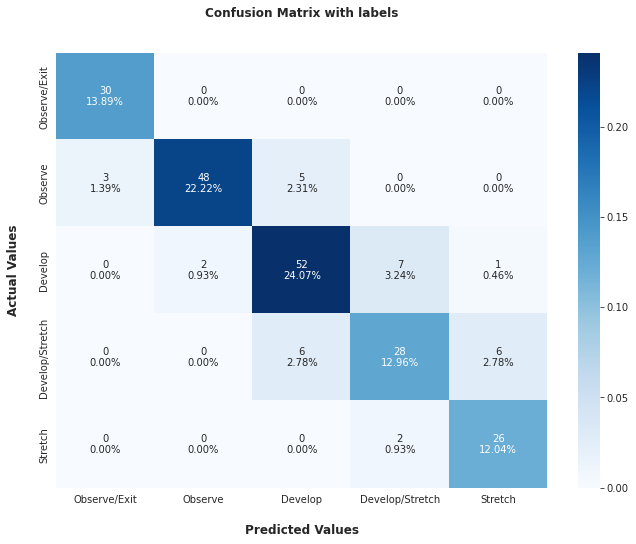

In [59]:
#plot confusion matrix
cm = confusion_matrix(y_true, y_pred_argmax)
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(5,5)
target_names = ['Observe/Exit','Observe','Develop','Develop/Stretch','Stretch']
ax = sns.heatmap(cm/np.sum(cm), annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix with labels\n\n', size='large', fontweight='bold');
ax.set_xlabel('\nPredicted Values',size='large', fontweight='bold')
ax.set_ylabel('Actual Values\n',size='large', fontweight='bold')
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names);

In [60]:
#print classification report
print(classification_report(y_true, y_pred_argmax, target_names=['Observe/Exit', 'Observe','Develop','Develop/Stretch','Stretch']))

                 precision    recall  f1-score   support

   Observe/Exit       0.91      1.00      0.95        30
        Observe       0.96      0.86      0.91        56
        Develop       0.83      0.84      0.83        62
Develop/Stretch       0.76      0.70      0.73        40
        Stretch       0.79      0.93      0.85        28

       accuracy                           0.85       216
      macro avg       0.85      0.86      0.85       216
   weighted avg       0.85      0.85      0.85       216



# Gradio

In [61]:
pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.1 MB 8.1 MB/s 
     |████████████████████████████████| 212 kB 53.2 MB/s 
     |████████████████████████████████| 53 kB 2.1 MB/s 
     |████████████████████████████████| 1.1 MB 45.2 MB/s 
     |████████████████████████████████| 54 kB 3.4 MB/s 
     |████████████████████████████████| 2.0 MB 53.3 MB/s 
     |████████████████████████████████| 84 kB 3.6 MB/s 
     |████████████████████████████████| 256 kB 79.5 MB/s 
     |████████████████████████████████| 144 kB 54.6 MB/s 
     |████████████████████████████████| 94 kB 4.2 MB/s 
     |████████████████████████████████| 271 kB 68.0 MB/s 
     |████████████████████████████████| 11.1 MB 56.2 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 80 kB 9.8 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 4.0 M

In [62]:
#load libraries 
import gradio as gr
import joblib

In [63]:
#load model
model = tf.keras.models.load_model('saved_model/sentiment_model_roberta')

In [64]:
#function to convert input text to 
def prep_data(text):
    tokens = tokenizer.encode_plus(text, max_length=256,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    # tokenizer returns int32 tensors, we need to return float64, so we use tf.cast
    return {'input_ids': tf.cast(tokens['input_ids'], tf.float64),
            'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}
def sentiment_analysis(message):
    #data = [prep_data(message)]
    probs = model.predict(prep_data(message))  
    sent = np.argmax(probs)
    result = ''
    if sent == 0:
      result = 'Observe / Exit'
    elif sent == 1:
      result = 'Observe'
    elif sent == 2:
      result = 'Develop'
    elif sent == 3:
      result = 'Develop / Stretch'
    else: 
      result = 'Stretch'
    return result

In [65]:
description='This app utilizes deep learning technology to facilitate talent management and succession planning in relation to the 9-box grid performance framework. Based on their characteristics and achievements, possible career development plans for the employees could be placed under one of the five main groups: Observe/Exit, Observe, Develop, Develop/Stretch, Stretch.'
article='Ref from Pingboard, <img src= "https://images.ctfassets.net/pp7p2httv5sw/38Zdeo4rXjP2f8sczLei4I/1234e5e30fa4b059d760e4c2864963bd/9-Box-Model-Example-2.png?w=1920&q=75&fit=fill&f=face"> '

examples = [
    ["Rachel Harper is a true virtuoso when it comes to task completion. She has been showing she can perform a task to a commendable grade at all times. Her talent has consistently been shining through. She is a joy to behold at the team."],
    ["Scott's performance over the last few months has been quite consistent. However, he needs to level up his technical abilities so that he can shine well. His core strength lies in grasping business requirements relatively quickly, however, he also needs to focus on translating the requirements into working software. Only when he combines his business acumen with technical abilities, he will be a real asset."],
    ["Brayden has been a member of our team for some time now. He has shown himself to be ineffective in the areas pertaining to his role. He does not show an aptitude for the work. He also shows no aptitude for building relationships with other team members."]
]

gradio_ui = gr.Interface(
    fn=sentiment_analysis, 
    title = 'Sentiment Analysis for Talent Management', 
    description=description,
    article=article,
    examples=examples,
    allow_flagging='never',
    inputs=gr.inputs.Textbox(lines=10, label='Input your review in the textbox, or select from one of the examples below. '), 
    outputs=[
        gr.outputs.Textbox(label='Based on input sentiment, a possible career development plan for this employee is:'),
    ],)

gradio_ui.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://10762.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<gradio.routes.App at 0x7ff0d5306c90>,
 'http://127.0.0.1:7860/',
 'https://10762.gradio.app')